#  Installation

In [19]:
!git clone https://github.com/cleardusk/3DDFA_V2.git
%cd 3DDFA_V2
!sh ./build.sh

Cloning into '3DDFA_V2'...
remote: Enumerating objects: 706, done.
remote: Total 706 (delta 0), reused 0 (delta 0), pack-reused 706 (from 1)
Receiving objects: 100% (706/706), 74.78 MiB | 17.46 MiB/s, done.
Resolving deltas: 100% (366/366), done.
/kaggle/working/3DDFA_V2/3DDFA_V2
running build_ext
cythoning nms/cpu_nms.pyx to nms/cpu_nms.c
/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /kaggle/working/3DDFA_V2/3DDFA_V2/FaceBoxes/utils/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'nms.cpu_nms' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/nms
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.7/site-packages/numpy/core/include -I/opt/conda/include/python3.7m 

In [20]:
!pip install face-alignment

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [21]:
import cv2
import yaml
from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix
import matplotlib.pyplot as plt
from skimage import io
from IPython.display import Image
import face_alignment
import dlib
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
from sklearn.metrics import mean_squared_error

In [22]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    !pip install onnxruntime
    
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX

    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    face_boxes = FaceBoxes()
    tddfa = TDDFA(gpu_mode=False, **cfg)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/torch/onnx/utils.py:958: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_shp
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))
/opt/conda/lib/python3.7/site-packages/torch/onnx/utils.py:958: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_exp
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))


Convert configs/bfm_noneck_v3.pkl to configs/bfm_noneck_v3.onnx done.
weights/mb1_120x120.onnx does not exist, try to convert the `.pth` version to `.onnx` online
Convert weights/mb1_120x120.pth to weights/mb1_120x120.onnx done.


# Helping Functions

In [23]:
# Function to detect 3D face landmarks
def detect_3d_landmarks(image_path):
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.THREE_D, device='cpu', flip_input=False)
    image = cv2.imread(image_path)
    landmarks = fa.get_landmarks(image)
    if landmarks is not None:
        return landmarks[0]
    else:
        return None

In [24]:
# Function to extract facial expressions
def extract_expression(landmarks):
    expression = {}

    # Mouth opening
    mouth_landmarks = landmarks[48:68] 
    upper_lip_center = np.mean(mouth_landmarks[0:3], axis=0)
    lower_lip_center = np.mean(mouth_landmarks[6:9], axis=0)
    mouth_opening = np.linalg.norm(upper_lip_center - lower_lip_center)
    expression['mouth_opening'] = mouth_opening

    # Eyebrow raising
    left_eyebrow_landmarks = landmarks[17:22]
    right_eyebrow_landmarks = landmarks[22:27]
    left_eye_center = np.mean(landmarks[36:42], axis=0)
    right_eye_center = np.mean(landmarks[42:48], axis=0)
    left_eyebrow_height = np.mean(np.linalg.norm(left_eyebrow_landmarks - left_eye_center, axis=1))
    right_eyebrow_height = np.mean(np.linalg.norm(right_eyebrow_landmarks - right_eye_center, axis=1))
    expression['eyebrow_raising'] = (left_eyebrow_height + right_eyebrow_height) / 2
    return expression

In [25]:
# Function to transfer expression to a target face
def transfer_expression(source_landmarks, target_landmarks, expression):
    modified_target_landmarks = target_landmarks.copy()

    # Mouth opening transfer
    source_mouth_opening = expression['mouth_opening']
    target_mouth_landmarks = modified_target_landmarks[48:68]
    upper_lip_center = np.mean(target_mouth_landmarks[0:3], axis=0)
    lower_lip_center = np.mean(target_mouth_landmarks[6:9], axis=0)
    target_mouth_opening = np.linalg.norm(upper_lip_center - lower_lip_center)
    scale_factor = source_mouth_opening / target_mouth_opening

    for i in range(len(target_mouth_landmarks)):
        modified_target_landmarks[48 + i] = upper_lip_center + scale_factor * (target_mouth_landmarks[i] - upper_lip_center)

    # Eyebrow raising transfer
    source_eyebrow_raising = expression['eyebrow_raising']
    target_left_eyebrow_landmarks = modified_target_landmarks[17:22]
    target_right_eyebrow_landmarks = modified_target_landmarks[22:27]
    target_left_eye_center = np.mean(modified_target_landmarks[36:42], axis=0)
    target_right_eye_center = np.mean(modified_target_landmarks[42:48], axis=0)
    target_left_eyebrow_height = np.mean(np.linalg.norm(target_left_eyebrow_landmarks - target_left_eye_center, axis=1))
    target_right_eyebrow_height = np.mean(np.linalg.norm(target_right_eyebrow_landmarks - target_right_eye_center, axis=1))
    target_eyebrow_raising = (target_left_eyebrow_height + target_right_eyebrow_height) / 2
    scale_factor = source_eyebrow_raising / target_eyebrow_raising

    for i in range(5):
        modified_target_landmarks[17 + i] = target_left_eye_center + scale_factor * (target_left_eyebrow_landmarks[i] - target_left_eye_center)
        modified_target_landmarks[22 + i] = target_right_eye_center + scale_factor * (target_right_eyebrow_landmarks[i] - target_right_eye_center)
    return modified_target_landmarks

In [26]:
# Function to apply modified landmarks to the target face (using Delaunay triangulation)
def apply_landmarks_to_face(target_image, modified_target_landmarks, source_image, source_landmarks):
    # Create Delaunay triangulation for both source and target landmarks
    source_hull = ConvexHull(source_landmarks[:, :2])  # 2D points for triangulation
    target_hull = ConvexHull(modified_target_landmarks[:, :2])

    # Find Delaunay triangles for source and target
    source_delaunay = Delaunay(source_landmarks[source_hull.vertices, :2])
    target_delaunay = Delaunay(modified_target_landmarks[target_hull.vertices, :2])

    # Iterate through each triangle in the target Delaunay triangulation
    for tri_indices in target_delaunay.simplices:
        # Get the corresponding triangle vertices from target and source landmarks
        target_tri = modified_target_landmarks[tri_indices, :2]
        source_tri = source_landmarks[tri_indices, :2]

        warp_mat = cv2.getAffineTransform(np.float32(source_tri), np.float32(target_tri))
        warped_triangle = cv2.warpAffine(source_image, warp_mat, (target_image.shape[1], target_image.shape[0]))

        mask = np.zeros(target_image.shape[:2], dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(target_tri), 255, 16, 0)

        target_image = cv2.seamlessClone(warped_triangle, target_image, mask, tuple(np.mean(target_tri, axis=0, dtype=int)), cv2.NORMAL_CLONE)

    return target_image

In [27]:
# Load 3DDFA_v2 model
def load_3ddfa_model():
    cfg = '/kaggle/working/3DDFA_V2/configs/mb1_120x120.yml'
    tddfa = TDDFA(gpu_mode=False, **yaml.load(open(cfg), Loader=yaml.SafeLoader))
    return tddfa

def detect_3d_landmarks_3ddfa(image_path, tddfa):
    image = cv2.imread(image_path)
    face_boxes = FaceBoxes()
    boxes = face_boxes(image)
    param_lst, roi_box_lst = tddfa(image, boxes)
    verts = tddfa.recon_vers(param_lst, roi_box_lst)
    return verts[0].T

In [28]:
# Landmark Deviation 
def landmark_deviation(source_landmarks, modified_target_landmarks):
    mse = mean_squared_error(source_landmarks, modified_target_landmarks)
    return mse

# Mouth Aspect Ratio (before and after transfer)
def mouth_aspect_ratio(landmarks):
    mouth_left = landmarks[48]  # Left corner of the mouth
    mouth_right = landmarks[54]  # Right corner of the mouth
    upper_lip = landmarks[51]  # Upper lip center
    lower_lip = landmarks[57]  # Lower lip center

    mouth_width = np.linalg.norm(mouth_left - mouth_right)
    mouth_height = np.linalg.norm(upper_lip - lower_lip)

    aspect_ratio = mouth_width / mouth_height
    return aspect_ratio

# Measure aspect ratio change between source and target
def aspect_ratio_change(source_landmarks, modified_target_landmarks):
    source_ratio = mouth_aspect_ratio(source_landmarks)
    target_ratio = mouth_aspect_ratio(modified_target_landmarks)
    return abs(source_ratio - target_ratio)

# Main pipeline

In [29]:
source_image_path = '/kaggle/input/fet-3ddfa/biden.jpeg'
target_image_path = '/kaggle/input/fet-3ddfa/trump.jpeg'

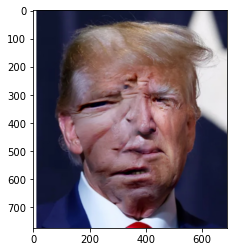

In [30]:
tddfa = load_3ddfa_model()

source_landmarks = detect_3d_landmarks_3ddfa(source_image_path, tddfa)
target_landmarks = detect_3d_landmarks_3ddfa(target_image_path, tddfa)

if source_landmarks is not None and target_landmarks is not None:
    source_expression = extract_expression(source_landmarks)
    modified_target_landmarks = transfer_expression(source_landmarks, target_landmarks, source_expression)

    source_image = cv2.imread(source_image_path)
    target_image = cv2.imread(target_image_path)
    modified_target_image = apply_landmarks_to_face(target_image, modified_target_landmarks, source_image, source_landmarks)

    plt.imshow(cv2.cvtColor(modified_target_image, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Face detection failed in one or both images.")


In [31]:
source_landmarks = detect_3d_landmarks_3ddfa(source_image_path, tddfa)
modified_target_landmarks = detect_3d_landmarks_3ddfa(target_image_path, tddfa)

if source_landmarks is not None and modified_target_landmarks is not None:
    # 1. Landmark Deviation
    mse_landmarks = landmark_deviation(source_landmarks, modified_target_landmarks)
    print(f"Landmark Deviation (MSE): {mse_landmarks}")

    # 2. Mouth Aspect Ratio Change
    ratio_change = aspect_ratio_change(source_landmarks, modified_target_landmarks)
    print(f"Mouth Aspect Ratio Change: {ratio_change}")


Landmark Deviation (MSE): 3657.599609375
Mouth Aspect Ratio Change: 1.1920671463012695
